In [ ]:
import os
import rioxarray
import numpy as np
import pandas as pd

# -----------------------------
# Settings
folder = r"C:\Ocean\Work\Projects\2025\Mangroves\Data\0_Workflow\areas_of_interest"
target_raster = r"C:\Ocean\Work\Projects\2025\Mangroves\Data\0_Workflow\areas_of_interest\REC_N00E117_S01E117_2025.tif"
id_tile = "N00E117"

# -----------------------------
# Find feature rasters
feature_rasters = []

for f in os.listdir(folder):
    if f.lower().endswith(".tif") and len(f.split("_")) > 1:
        second_elem = f.split("_")[1]
        
        if f.startswith("GMW"):
            continue
        if second_elem != id_tile:
            continue
        if f.startswith("R25") and not f.endswith("_2020.tif"):
            continue
        
        feature_rasters.append(os.path.join(folder, f))

print(f"Found {len(feature_rasters)} raster(s)")

# -----------------------------
# Load feature rasters
feature_arrays = []
feature_names = []

for f in feature_rasters:
    da = rioxarray.open_rasterio(f, masked=True)
    feature_arrays.append(da.values.flatten())
    # Use first three letters of filename as feature name
    feature_names.append(os.path.basename(f)[:3])

# Stack features as columns
X = np.vstack(feature_arrays).T

# -----------------------------
# Load target raster
y = rioxarray.open_rasterio(target_raster, masked=True).values.flatten()

# -----------------------------
# Combine into DataFrame
df = pd.DataFrame(X, columns=feature_names)
# df['target'] = y

df.fillna(0, inplace=True)
tmp = df.drop(columns=["GTS"], errors="ignore")
df["total"] = tmp.sum(axis=1)
df = df[df["total"] != 0]

df.drop(columns=['R25', 'total'], inplace=True)
df = df[~((df["HIS"] == 0) & (df["REC"] == 0))]

# Función para convertir valores de HIS
def convert_his(value):
    if value <= 2019:
        return 1
    else:
        return 0  # opcional: mantiene otros valores sin cambio

# Función para convertir valores de REC
def convert_rec(value):
    if value >= 2007:
        return 2
    else:
        return 0
    
# Aplicar la función a la columna HIS
df["HIS"] = df["HIS"].apply(convert_his)

df["REC"] = df["REC"].apply(convert_rec)

# Crear columna HIS_REC sumando HIS + REC
df["HIS_REC"] = df["HIS"] + df["REC"]

df.drop(columns=['ACC', 'HIS', 'REC'], inplace=True)

sample0 = df[df["HIS_REC"] == 0].sample(n=5000, random_state=42)
sample1 = df[df["HIS_REC"] == 1].sample(n=5000, random_state=42)
sample2 = df[df["HIS_REC"] == 2].sample(n=5000, random_state=42)

df_sampled = pd.concat([sample0, sample1, sample2], ignore_index=True)

df_sampled

Found 11 raster(s)


,ELE,GTS,HAT,LAN,MSL,PON,SEE,HIS_REC
0,1.667401,2.391,0.0,0.0,1.0,0.0,4.0,0
1,1.658848,2.391,0.0,0.0,1.0,1.0,4.0,0
2,1.547408,2.332,0.0,0.0,1.0,0.0,4.0,0
3,1.592810,2.332,0.0,0.0,1.0,0.0,4.0,0
4,2.142594,2.272,0.0,0.0,1.0,0.0,4.0,0
...,...,...,...,...,...,...,...,...
14995,0.000000,2.272,0.0,0.0,0.0,1.0,4.0,2
14996,1.329547,2.252,0.0,0.0,1.0,0.0,4.0,2
14997,0.000000,2.253,0.0,0.0,0.0,1.0,4.0,2
14998,1.482672,2.332,0.0,0.0,1.0,0.0,4.0,2


HIS_REC    1.000000
PON        0.063765
LAN        0.021219
SEE        0.000173
HAT       -0.057247
GTS       -0.146446
ELE       -0.210657
MSL       -0.212065
Name: HIS_REC, dtype: float64


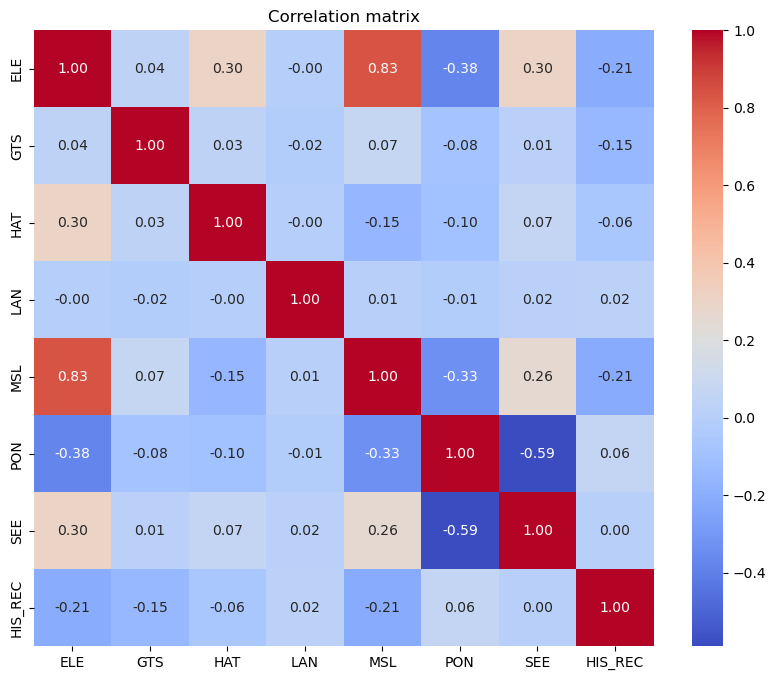

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Correlation matrix
correlation_matrix = df_sampled.corr()
print(correlation_matrix["HIS_REC"].sort_values(ascending=False))

# Visualizar la correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()



In [ ]:
# -----------------------------
# Prepare data for ML
X_ml = df_sampled.drop(columns=["HIS_REC"])
y_ml = df_sampled["HIS_REC"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.3, random_state=42, stratify=y_ml
)

# -----------------------------
# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# -----------------------------
# Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X_ml.columns)
importances = importances.sort_values(ascending=False)
print("\nFeature Importances:")
importances

Confusion Matrix:
[[ 938    0  562]
 [   0 1500    0]
 [ 417    1 1082]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      1500
           1       1.00      1.00      1.00      1500
           2       0.66      0.72      0.69      1500

    accuracy                           0.78      4500
   macro avg       0.78      0.78      0.78      4500
weighted avg       0.78      0.78      0.78      4500


Feature Importances:


SEE    0.448170
ELE    0.368744
PON    0.081891
GTS    0.078329
MSL    0.020601
HAT    0.002088
LAN    0.000177
dtype: float64

In [ ]:
import os
import rioxarray
import numpy as np
import pandas as pd

# -----------------------------
# Settings
folder = r"C:\Ocean\Work\Projects\2025\Mangroves\Data\0_Workflow\areas_of_interest"
target_raster = r"C:\Ocean\Work\Projects\2025\Mangroves\Data\0_Workflow\areas_of_interest\REC_N00E117_S01E117_2025.tif"
id_tile = "N00E117"

# -----------------------------
# Find feature rasters
feature_rasters = []

for f in os.listdir(folder):
    if f.lower().endswith(".tif") and len(f.split("_")) > 1:
        second_elem = f.split("_")[1]
        
        if f.startswith("GMW"):
            continue
        if second_elem != id_tile:
            continue
        if f.startswith("R25") and not f.endswith("_2020.tif"):
            continue
        
        feature_rasters.append(os.path.join(folder, f))

print(f"Found {len(feature_rasters)} raster(s)")

# -----------------------------
# Load feature rasters
feature_arrays = []
feature_names = []

for f in feature_rasters:
    da = rioxarray.open_rasterio(f, masked=True)
    feature_arrays.append(da.values.flatten())
    # Use first three letters of filename as feature name
    feature_names.append(os.path.basename(f)[:3])

# Stack features as columns
X = np.vstack(feature_arrays).T

# -----------------------------
# Load target raster
y = rioxarray.open_rasterio(target_raster, masked=True).values.flatten()

# -----------------------------
# Combine into DataFrame
df = pd.DataFrame(X, columns=feature_names)
# df['target'] = y

df.fillna(0, inplace=True)
tmp = df.drop(columns=["GTS"], errors="ignore")
df["total"] = tmp.sum(axis=1)
df = df[df["total"] != 0]

df.drop(columns=['R25', 'total'], inplace=True)
df = df[~((df["HIS"] == 0) & (df["REC"] == 0))]

# Función para convertir valores de REC
def convert_rec(value):
    if value >= 2007:
        return 1
    else:
        return 0
    
df["REC"] = df["REC"].apply(convert_rec)

# Crear columna HIS_REC sumando HIS + REC
df["HIS_REC"] = df["REC"]

df.drop(columns=['ACC', 'HIS', 'REC'], inplace=True)

sample0 = df[df["HIS_REC"] == 0].sample(n=5000, random_state=42)
sample1 = df[df["HIS_REC"] == 1].sample(n=5000, random_state=42)

df_sampled = pd.concat([sample0, sample1], ignore_index=True)

df_sampled

Found 11 raster(s)


,ELE,GTS,HAT,LAN,MSL,PON,SEE,HIS_REC
0,0.000000,2.272,0.0,0.0,0.0,1.0,3.0,0
1,1.331232,2.454,0.0,0.0,1.0,0.0,4.0,0
2,1.330243,2.391,0.0,0.0,1.0,0.0,4.0,0
3,1.670781,2.332,0.0,0.0,1.0,0.0,4.0,0
4,0.000000,2.253,0.0,0.0,0.0,1.0,3.0,0
...,...,...,...,...,...,...,...,...
9995,0.000000,2.332,0.0,0.0,0.0,1.0,3.0,1
9996,0.000000,2.391,0.0,0.0,0.0,0.0,4.0,1
9997,1.351904,2.454,0.0,0.0,1.0,0.0,4.0,1
9998,0.000000,2.332,0.0,0.0,0.0,1.0,3.0,1


In [ ]:
import pandas as pd
from scipy.stats import pointbiserialr

# List of variables as strings
variables = ["ELE", "GTS", "HAT", "LAN", "MSL", "PON", "SEE"]

print("Point-biserial correlation with 'HIS_REC':\n")
for var in variables:
    r, p = pointbiserialr(df_sampled[var], df_sampled['HIS_REC'])
    print(f"{var}: r = {r:.3f}, p-value = {p:.3f}")


Point-biserial correlation with 'HIS_REC':

ELE: r = -0.109, p-value = 0.000
GTS: r = -0.112, p-value = 0.000
HAT: r = -0.031, p-value = 0.002
LAN: r = 0.020, p-value = 0.045
MSL: r = -0.120, p-value = 0.000
PON: r = -0.136, p-value = 0.000
SEE: r = 0.078, p-value = 0.000


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

# -----------------------------
# Function to compute correlation ratio for numeric vs categorical
# -----------------------------
def correlation_ratio(categories, measurements):
    """
    Compute correlation ratio (eta-squared) between a categorical target and a numeric variable.
    """
    categories = np.array(categories)
    measurements = np.array(measurements)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1

    y_mean = np.mean(measurements)
    n_total = len(measurements)
    ss_between = 0
    for i in range(cat_num):
        cat_values = measurements[fcat == i]
        n_i = len(cat_values)
        if n_i > 0:
            ss_between += n_i * (np.mean(cat_values) - y_mean)**2
    ss_total = np.sum((measurements - y_mean)**2)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    return eta_squared

# -----------------------------
# Compute correlations
# -----------------------------
variables = ["ELE", "GTS", "HAT", "LAN", "MSL", "PON", "SEE"]
target = "HIS_REC"

# Check if target is binary
unique_classes = df_sampled[target].nunique()
print(f"Target '{target}' has {unique_classes} unique classes.\n")

for var in variables:
    if unique_classes == 2:  # Binary: use point-biserial
        r, p = pointbiserialr(df_sampled[var], df_sampled[target])
        print(f"{var}: point-biserial r = {r:.3f}, p-value = {p:.3f}")
    else:  # Multi-class: use correlation ratio
        eta = correlation_ratio(df_sampled[target], df_sampled[var])
        print(f"{var}: correlation ratio (eta²) = {eta:.3f}")


Target 'HIS_REC' has 2 unique classes.

ELE: point-biserial r = -0.109, p-value = 0.000
GTS: point-biserial r = -0.112, p-value = 0.000
HAT: point-biserial r = -0.031, p-value = 0.002
LAN: point-biserial r = 0.020, p-value = 0.045
MSL: point-biserial r = -0.120, p-value = 0.000
PON: point-biserial r = -0.136, p-value = 0.000
SEE: point-biserial r = 0.078, p-value = 0.000


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

# -----------------------------
# Function to compute correlation ratio for numeric vs categorical
# -----------------------------
def correlation_ratio(categories, measurements):
    """
    Compute correlation ratio (eta-squared) between a categorical target and a numeric variable.
    """
    categories = np.array(categories)
    measurements = np.array(measurements)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1

    y_mean = np.mean(measurements)
    n_total = len(measurements)
    ss_between = 0
    for i in range(cat_num):
        cat_values = measurements[fcat == i]
        n_i = len(cat_values)
        if n_i > 0:
            ss_between += n_i * (np.mean(cat_values) - y_mean)**2
    ss_total = np.sum((measurements - y_mean)**2)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    return eta_squared

# -----------------------------
# Compute correlations
# -----------------------------
variables = ["ELE", "GTS", "HAT", "LAN", "MSL", "PON", "SEE"]
target = "HIS_REC"

# Check if target is binary
unique_classes = df_sampled[target].nunique()
print(f"Target '{target}' has {unique_classes} unique classes.\n")

for var in variables:
    if unique_classes == 2:  # Binary: use point-biserial
        r, p = pointbiserialr(df_sampled[var], df_sampled[target])
        print(f"{var}: point-biserial r = {r:.3f}, p-value = {p:.3f}")
    else:  # Multi-class: use correlation ratio
        eta = correlation_ratio(df_sampled[target], df_sampled[var])
        print(f"{var}: correlation ratio (eta²) = {eta:.3f}")


Target 'HIS_REC' has 3 unique classes.

ELE: correlation ratio (eta²) = 0.133
GTS: correlation ratio (eta²) = 0.022
HAT: correlation ratio (eta²) = 0.008
LAN: correlation ratio (eta²) = 0.001
MSL: correlation ratio (eta²) = 0.111
PON: correlation ratio (eta²) = 0.354
SEE: correlation ratio (eta²) = 0.997


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

# -----------------------------
# Function to compute correlation ratio for numeric vs categorical
# -----------------------------
def correlation_ratio(categories, measurements):
    categories = np.array(categories)
    measurements = np.array(measurements)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1

    y_mean = np.mean(measurements)
    ss_between = 0
    for i in range(cat_num):
        cat_values = measurements[fcat == i]
        n_i = len(cat_values)
        if n_i > 0:
            ss_between += n_i * (np.mean(cat_values) - y_mean)**2
    ss_total = np.sum((measurements - y_mean)**2)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    return eta_squared

# -----------------------------
# Create fake dataset
# -----------------------------
data = []

# 50 men, 50 women, 50 kids
for i in range(50):
    data.append({'man': 1, 'woman': 0, 'kids': 0, 'day': 'Friday'})
for i in range(50):
    data.append({'man': 0, 'woman': 1, 'kids': 0, 'day': 'Saturday'})
for i in range(50):
    data.append({'man': 0, 'woman': 0, 'kids': 1, 'day': 'Monday'})

df_sampled = pd.DataFrame(data)

# -----------------------------
# Compute correlations
# -----------------------------
variables = ['man', 'woman', 'kids']
target = 'day'

unique_classes = df_sampled[target].nunique()
print(f"Target '{target}' has {unique_classes} unique classes.\n")

for var in variables:
    if unique_classes == 2:  # Binary: use point-biserial
        r, p = pointbiserialr(df_sampled[var], df_sampled[target])
        print(f"{var}: point-biserial r = {r:.3f}, p-value = {p:.3f}")
    else:  # Multi-class: use correlation ratio
        eta = correlation_ratio(df_sampled[target], df_sampled[var])
        print(f"{var}: correlation ratio (eta²) = {eta:.3f}")


Target 'day' has 3 unique classes.

man: correlation ratio (eta²) = 1.000
woman: correlation ratio (eta²) = 1.000
kids: correlation ratio (eta²) = 1.000


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

# -----------------------------
# Function to compute correlation ratio for numeric vs categorical
# -----------------------------
def correlation_ratio(categories, measurements):
    categories = np.array(categories)
    measurements = np.array(measurements)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1

    y_mean = np.mean(measurements)
    ss_between = 0
    for i in range(cat_num):
        cat_values = measurements[fcat == i]
        n_i = len(cat_values)
        if n_i > 0:
            ss_between += n_i * (np.mean(cat_values) - y_mean)**2
    ss_total = np.sum((measurements - y_mean)**2)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    return eta_squared

# -----------------------------
# Create fake dataset with some kids buying on other days
# -----------------------------
data = []

# 50 men, all buy Friday
for i in range(50):
    data.append({'man': 1, 'woman': 0, 'kids': 0, 'day': 'Friday'})

# 50 women, all buy Saturday
for i in range(50):
    data.append({'man': 0, 'woman': 1, 'kids': 0, 'day': 'Saturday'})

# 50 kids, 80% buy Monday, 20% buy Friday or Saturday randomly
np.random.seed(42)  # for reproducibility
for i in range(50):
    if np.random.rand() < 0.8:
        day = 'Monday'
    else:
        day = np.random.choice(['Friday', 'Saturday'])
    data.append({'man': 0, 'woman': 0, 'kids': 1, 'day': day})

df_sampled = pd.DataFrame(data)

# -----------------------------
# Compute correlations
# -----------------------------
variables = ['man', 'woman', 'kids']
target = 'day'

unique_classes = df_sampled[target].nunique()
print(f"Target '{target}' has {unique_classes} unique classes.\n")

for var in variables:
    if unique_classes == 2:  # Binary: use point-biserial
        r, p = pointbiserialr(df_sampled[var], df_sampled[target])
        print(f"{var}: point-biserial r = {r:.3f}, p-value = {p:.3f}")
    else:  # Multi-class: use correlation ratio
        eta = correlation_ratio(df_sampled[target], df_sampled[var])
        print(f"{var}: correlation ratio (eta²) = {eta:.3f}")


Target 'day' has 3 unique classes.

man: correlation ratio (eta²) = 0.942
woman: correlation ratio (eta²) = 0.864
kids: correlation ratio (eta²) = 0.806
